## Import Packages

In [1]:
import os
import plotly
import matplotlib
import pandas as pd
import fbprophet as ph

%matplotlib inline
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot
from pandas.plotting import autocorrelation_plot


from math import floor, ceil, sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

matplotlib.rcParams['figure.figsize'] = (12, 6)
axis_formatter = matplotlib.dates.DateFormatter('%Y-%m-%d %Hh') 


## Import Dataset
### Source
Hourly energy demand generation and weather  
https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather
### Content

This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. Weather data was purchased as part of a personal project from the Open Weather API for the 5 largest cities in Spain and made public here.  
  
  
### Inspirational Problems to Solve
- What weather measurements, and cities influence most the electrical demand, prices, generation capacity?
- Forecast 24 hours in advance?
- Predict electrical price by time of day?
- Forecast intraday price or electrical demand hour-by-hour.

In [2]:
## simple dataset
shampoo_df = pd.read_csv('dataset/shampoo_sale/shampoo.csv')
print(shampoo_df.shape)

## richer and more complex datasets
# hourly_energy_df = pd.read_csv('dataset/hourly_energy_demand_generation_and_weather/energy_dataset.csv')
# hourly_weather_df = pd.read_csv('dataset/hourly_energy_demand_generation_and_weather/weather_features.csv')
# print(hourly_energy_df.shape)
# print(hourly_weather_df.shape)

(36, 2)


In [3]:
shampoo_df.head()

,Month,Sales
0,01/01/2018,266.0
1,01/02/2018,145.9
2,01/03/2018,183.1
3,01/04/2018,119.3
4,01/05/2018,180.3


## Data Prep


In [4]:
type(shampoo_df['Month'].iloc[0])

str

In [5]:
shampoo_df['Month'] = pd.to_datetime(shampoo_df['Month'], format='%d/%m/%Y', utc=True).dt.date

In [6]:
type(shampoo_df['Month'].iloc[0])

datetime.date

## Building a ARIMA model

**ARIMA = AR + I + MA**  
  
  
**AR**: *Autoregression*. A model that uses the dependent relationship between an observation and some number of lagged observations.  
<br>
<center>$y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2} + ... + \phi_1y_{t-p} + \epsilon_t$ </center>
  
**I**: *Integrated*. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
  
**MA**: *Moving Average*. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.  
<br>
<center>$y_t = c + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_1\epsilon_{t-q}$ </center>
<br>

A MA model with order 1 (i.e. $q=1$)  
<br>
<center>$y_t = c + \epsilon_t + \theta_1\epsilon_{t-1}$
<br>

The parameters of the ARIMA model are defined as follows:  
  
**p** : The number of lag observations included in the model, also called the lag order.  

**d**: The number of times that the raw observations are differenced, also called the degree of differencing.  

**q**: The size of the moving average window, also called the order of moving average.  


In [4]:
shampoo_df.head()

,Month,Sales
0,2018-01-01,266.0
1,2018-02-01,145.9
2,2018-03-01,183.1
3,2018-04-01,119.3
4,2018-05-01,180.3


### Determining I

#### Explain "stationary"
if $y_t$ is a stationary time series, then for all $s$, the distribution of $y_t,...,y_{t+s}$ does not depend on $t$.  

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.  
  
In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.  

![stationary](img/time_series_001.png)  
  
Which of these series are stationary?  
(a) Google stock price for 200 consecutive days;  
(b) Daily change in the Google stock price for 200 consecutive days;  
(c) Annual number of strikes in the US;  
(d) Monthly sales of new one-family houses sold in the US;  
(e) Annual price of a dozen eggs in the US (constant dollars);  
(f) Monthly total of pigs slaughtered in Victoria, Australia.  

<br>
  
**Trend? Seasonality?**  

<br>
  
Trends and changing levels rules out series (a), (c), (e), (f). Seasonality rules out series (d).  

**Why do we need stationary?**  
  
What quantities are we typically interested in when we perform statistical analysis on a time series? We want to know  

- Its expected value,
- Its variance, 
- The correlation between values $t$ periods apart for a set of $t$ values.
  
How do we calculate these things? Using a mean across many time periods.

The mean across many time periods is only informative if the expected value is the same across those time periods. If these population parameters can vary, what are we really estimating by taking an average across time?  
  
A stationary time series is one whose mean and variance is constant over time. It is required for sample statistics such as means, variances, and correlations to accurately describe the data at all time points of interest.  
  
Looking at the period $200<t<400$ and $600<t<800$ in the two time series plots below, the mean and variance of any given segment of time do a good job representing the whole stationary time series. 

![stationary_001](img/time_series_stationary_001.png)

but a relatively poor job representing the whole non-stationary time series. For instance, the mean of the non-stationary time series is much lower from $600<𝑡<800$  and its variance is much higher in this range than in the range from $200<𝑡<400$

![non-stationary_002](img/time_series_stationary_002.png)

#### Explain "differencing"
Revisiting the examples
![stationary](img/time_series_001.png) 

(a) Google stock price for 200 consecutive days;  
(b) Daily change in the Google stock price for 200 consecutive days;  

<br>

Note that the Google stock price was non-stationary in panel (a), but the daily changes were stationary in panel (b). This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as **differencing**.  
  
Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.  

The difference of a Series element compared with another element in the Series

In [7]:
tmp_ls = [2,3,5,4,2,1,3,6,9]
pd.Series(tmp_ls)

0    2
1    3
2    5
3    4
4    2
5    1
6    3
7    6
8    9
dtype: int64

In [8]:
pd.concat([pd.Series(tmp_ls), pd.Series(tmp_ls).diff(periods=1)], axis=1)

,0,1
0,2,NaN
1,3,1.0
2,5,2.0
3,4,-1.0
4,2,-2.0
5,1,-1.0
6,3,2.0
7,6,3.0
8,9,3.0


In [9]:
pd.concat([pd.Series(tmp_ls), pd.Series(tmp_ls).diff(periods=3)], axis=1)

,0,1
0,2,NaN
1,3,NaN
2,5,NaN
3,4,2.0
4,2,-1.0
5,1,-4.0
6,3,-1.0
7,6,4.0
8,9,8.0


#### Check stationarity 

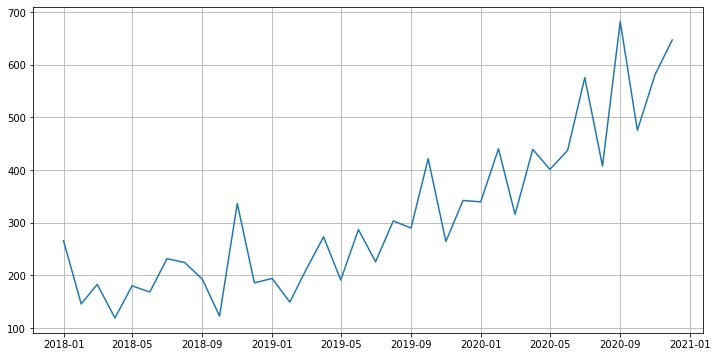

In [10]:
plt.plot(shampoo_df.Month,shampoo_df.Sales)
plt.grid(True)
plt.show()

This suggests that the time series is __not stationary__ and will require differencing to make it stationary, at least a difference order of 1.

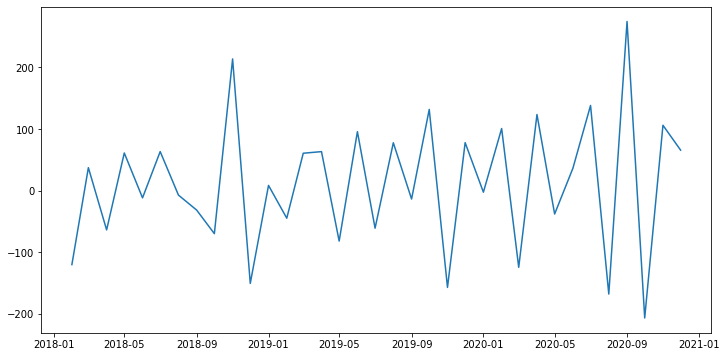

In [11]:
plt.plot(shampoo_df.Month, shampoo_df.Sales.diff(periods=1))

**Seasonal differencing**  
A seasonal difference is the difference between an observation and the previous observation from the same season. 

<br>

<center> $ y_t^, = y_t - y_{t-m} $ </center>


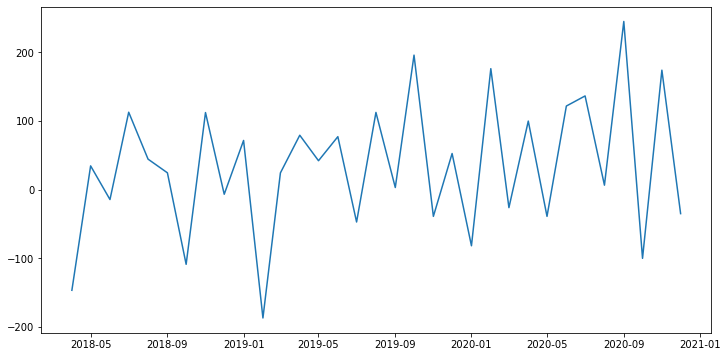

In [12]:
plt.plot(shampoo_df.Month, shampoo_df.Sales.diff(periods=3))

**Second-order differencing**  
Occasionally the differenced data will not appear to be stationary and it may be necessary to difference the data a second time to obtain a stationary series.  

<br>

$ y^{,,}_t = y_t^, - y_{t-1}^, $  
$ y^{,,}_t = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) $  
$ y^{,,}_t = y_t - 2y_{t-1} + y_{t-2} $   
  
Then, we would model the “change in the changes” of the original data. In practice, it is almost never necessary to go beyond second-order differences.

### Determining p with ACF
ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

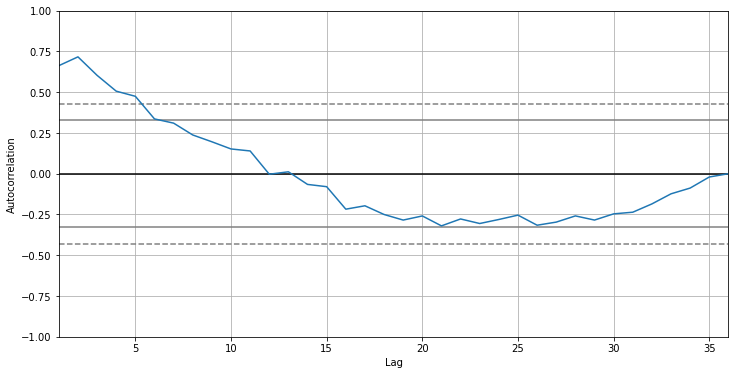

In [13]:
## Use autocorrelation_plot from pandas
autocorrelation_plot(shampoo_df.Sales)

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.  
A good starting point for the AR parameter of the model may be 5

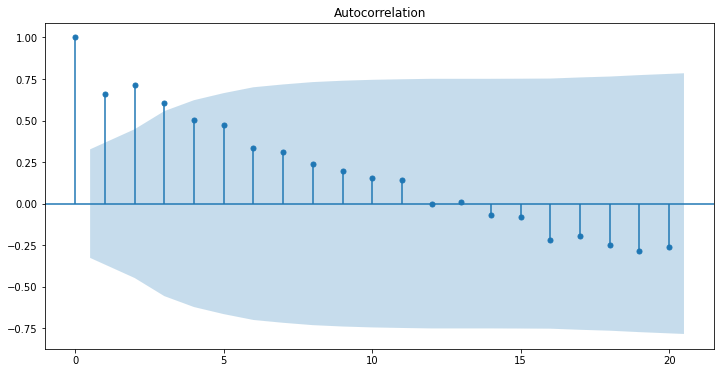

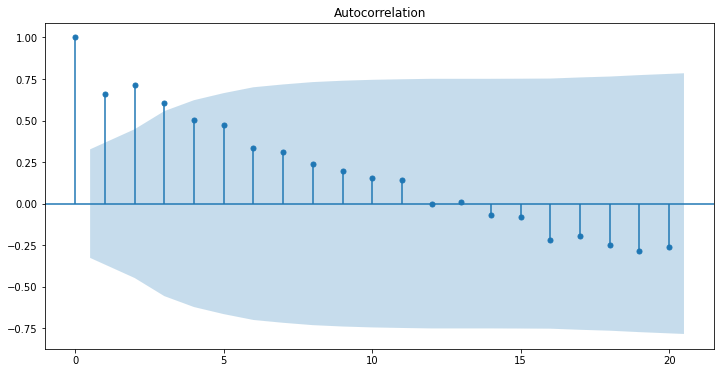

In [14]:
## Alternative use plot_acf from statsmodel
plot_acf(shampoo_df.Sales, lags=20)

**Side note**:  
The ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.  
  
Check whether the chosen $I$ in previous section is appropriate.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

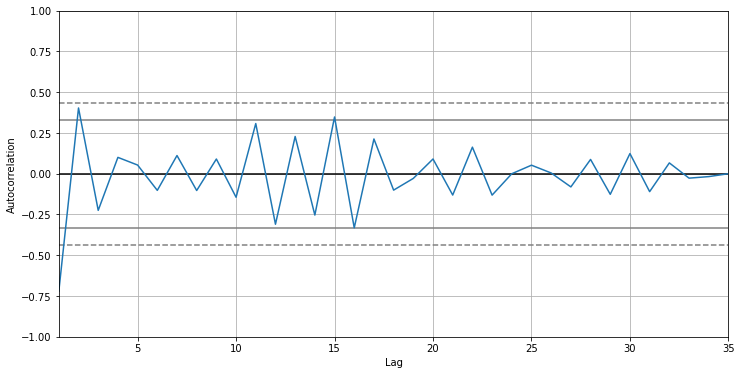

In [15]:
autocorrelation_plot(shampoo_df.Sales.diff(periods=1)[1:])


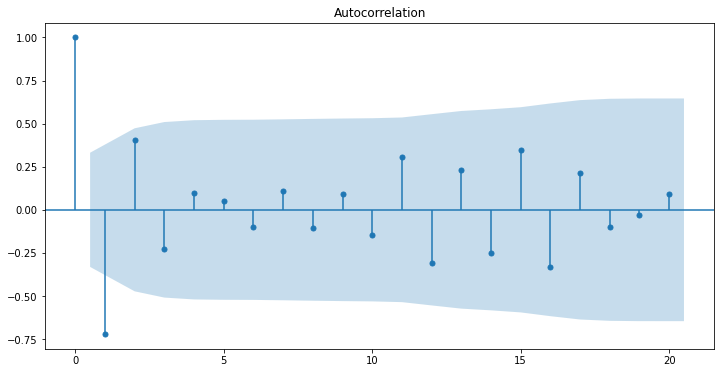

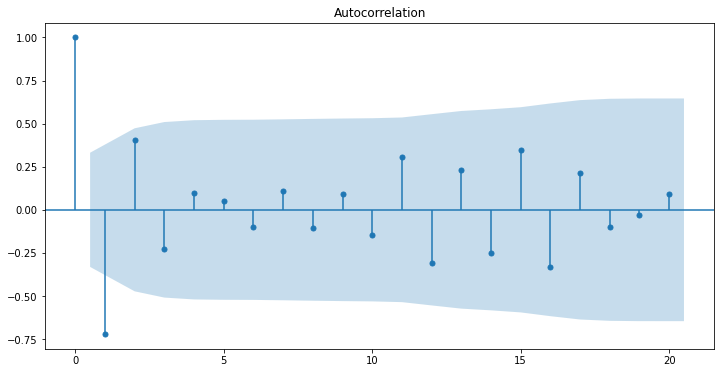

In [16]:
plot_acf(shampoo_df.Sales.diff(periods=1)[1:], lags=20)

### Determining q with PACF
PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

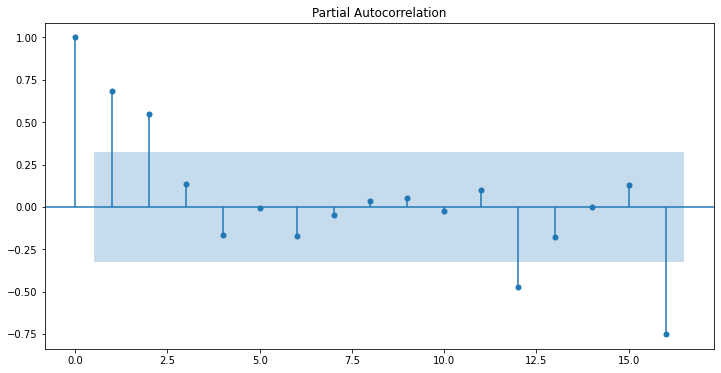

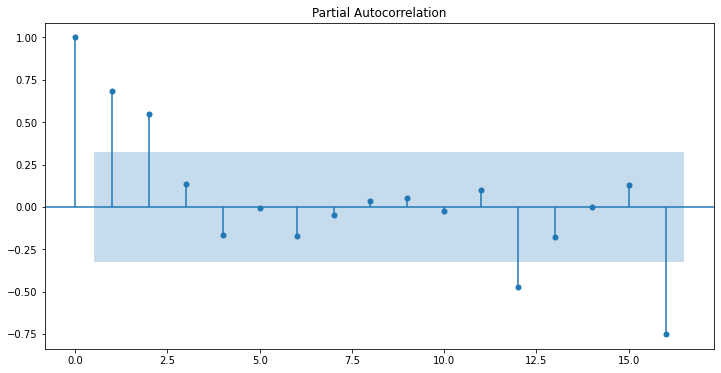

In [17]:
plot_pacf(shampoo_df.Sales)

### Training a ARIMA model

In [18]:
hist_size = 3/5
shampoo_hist = shampoo_df.head(floor(hist_size * len(shampoo_df)))
shampoo_test = shampoo_df.tail(ceil((1-hist_size) * len(shampoo_df)))

In [19]:
model = ARIMA(shampoo_hist.Sales, order=(5,1,2))
model_fit = model.fit()

/Users/cheuky/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [20]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   21
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -108.262
Date:                Sun, 18 Apr 2021   AIC                            232.525
Time:                        01:41:59   BIC                            240.491
Sample:                             0   HQIC                           234.080
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3149      0.648     -3.575      0.000      -3.584      -1.046
ar.L2         -2.6198      1.001     -2.618      0.009      -4.581      -0.658
ar.L3         -2.0243      1.025     -1.974      0.048      -4.034      -0.015
ar.L4         -1.3174      0.899     -1.465      0.143      -3.080       0.445
ar.L5         -0.4767      0.432     -1.104      0.270      -1.323       0.370
ma.L1          1.5003      1.660      0.904      0.366      -1.754       4.754
ma.L2          0.9262      1.861      0.498      0.619      -2.722       4.574
sigma2      2377.6497   3898.444      0.610      0.542   -5263.161       1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.63   Prob(JB):                         0.76
Heteroskedasticity (H):               0.58   Skew:                             0.31
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'Line plot of residuals')

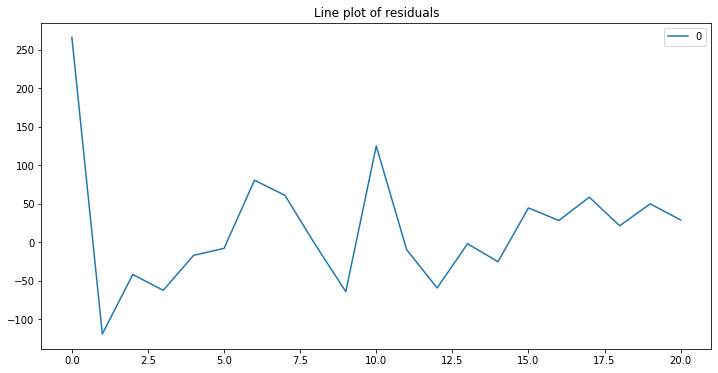

In [21]:
residuals = pd.DataFrame(model_fit.resid)

## line plot of residuals
residuals.plot()
plt.title('Line plot of residuals')

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian (normal distribution), but may not be centered on zero

Text(0.5, 1.0, 'Density plot of residuals')

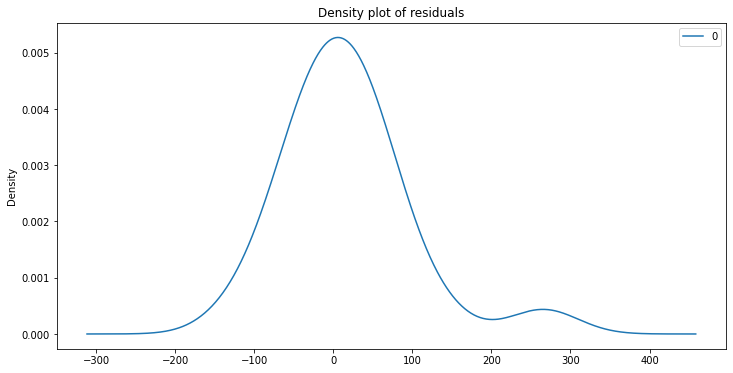

In [22]:
## density plot of residuals
residuals.plot(kind='kde')
plt.title('Density plot of residuals')

In [23]:
residuals.describe()

,0
count,21.000000
mean,16.901268
std,80.351494
min,-118.924768
25%,-25.137262
50%,-1.751320
75%,50.005043
max,266.000000


The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

### Making forecast

In [25]:
shampoo_hist.tail()

,Month,Sales
16,2019-05-01,191.4
17,2019-06-01,287.0
18,2019-07-01,226.0
19,2019-08-01,303.6
20,2019-09-01,289.9


In [26]:
output = model_fit.forecast()
output

21    242.444572
dtype: float64

In [27]:
history = [x for x in shampoo_hist.Sales]
test = [x for x in shampoo_test.Sales]
predictions = list()

for t in range(len(shampoo_test)):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
shampoo_forecast = pd.DataFrame({'expected':test, 'predicted':predictions})

/Users/cheuky/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/cheuky/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/cheuky/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/cheuky/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/cheuky/anaconda3/envs/timeseries/lib

In [28]:
shampoo_forecast

,expected,predicted
0,421.6,242.444572
1,264.5,274.965208
2,342.3,322.346806
3,339.7,321.739125
4,440.4,396.797580
5,315.9,349.740532
6,439.3,362.678839
7,401.3,310.774146
8,437.4,455.816824
9,575.5,402.788345


In [33]:
rmse = sqrt(mean_squared_error(test, predictions))
rmse

85.33451106961036

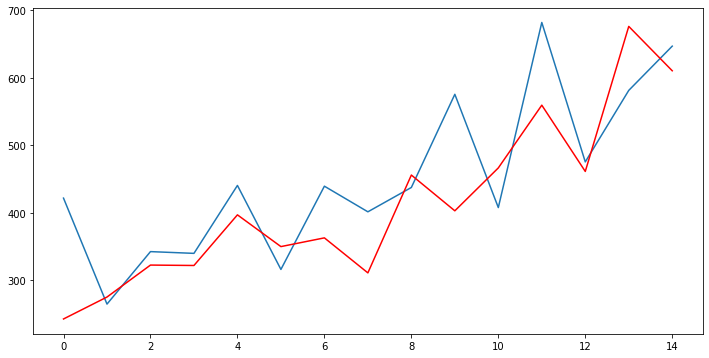

In [32]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Predict with Prophet  
Data preprocessing

In [ ]:
hourly_energy_df.columns

In [ ]:
hourly_energy_df['time'] = pd.to_datetime(hourly_energy_df['time'], utc=True)
# Remove timezone
hourly_energy_df['time'] = hourly_energy_df['time'].dt.tz_localize(None)
hourly_energy_df.sort_values('time', inplace=True)
print(len(hourly_energy_df))

Split to create historical data (training set)

In [ ]:
hist_size = 3/5
hourly_energy_hist = hourly_energy_df.head(floor(hist_size * len(hourly_energy_df)))[['time', 'price day ahead']]

Prophet requires time series data to have a minimum of two columns: `ds` which is the time stamp and `y` which is the values

In [ ]:
hourly_energy_hist.columns = ['ds', 'y']
hourly_energy_hist.shape

Convert hourly data to daily average

In [ ]:
daily_energy_df = hourly_energy_df.groupby([hourly_energy_df['time'].dt.date]).mean().reset_index()
daily_energy_df.head(3)

hist_size = 3/5
daily_energy_hist = daily_energy_df.head(floor(hist_size * len(daily_energy_df)))[['time', 'price day ahead']]
daily_energy_hist.columns = ['ds', 'y']
daily_energy_hist.shape

In [97]:
prophet = ph.Prophet()

In [98]:
prophet.fit(df=daily_energy_hist)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [99]:
## Add in 365 days in future, unit is day
# energy_future = prophet.make_future_dataframe(periods=365, freq='D')

## OR add in 1 year in future, unit is month 
energy_future = prophet.make_future_dataframe(periods=12 * 1, freq='M')

## OR add in 2 years in future, unit is year 
# energy_future = prophet.make_future_dataframe(periods=2, freq='Y')

In [100]:
energy_future.tail()

,ds
884,2017-12-31
885,2018-01-31
886,2018-02-28
887,2018-03-31
888,2018-04-30


In [101]:
forecast = prophet.predict(energy_future)

In [102]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
884,2017-12-31,70.910883,56.580816,83.969639
885,2018-01-31,85.131458,71.331725,99.362361
886,2018-02-28,75.427331,61.201057,89.622206
887,2018-03-31,71.630240,55.576768,85.772333
888,2018-04-30,78.227038,63.562049,93.336329


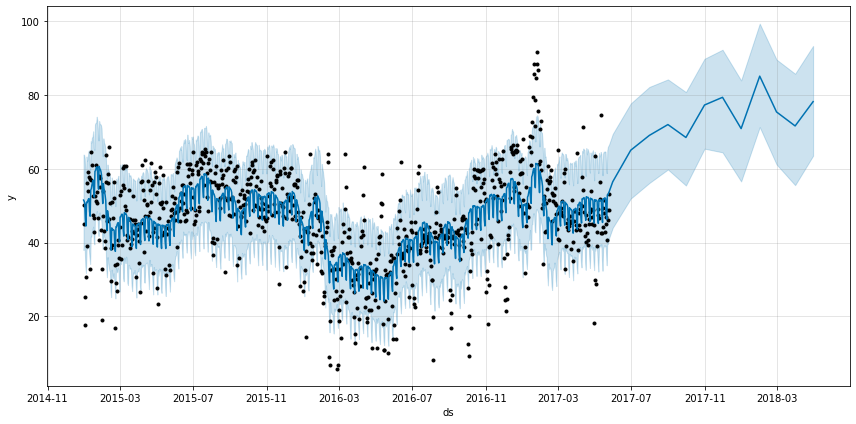

In [103]:
fig1 = prophet.plot(forecast, figsize=(12,6))

Prophet has included the original data as the black dots and the blue line is the forecast model. The light blue area is the confidence interval. Using the `add_changepoints_to_plot` function added the red lines; the vertical dashed lines are changepoints Prophet identified where the trend changed, and the solid red line is the trend with all seasonality removed. 

In [104]:
a = add_changepoints_to_plot(fig1.gca(), prophet, forecast)

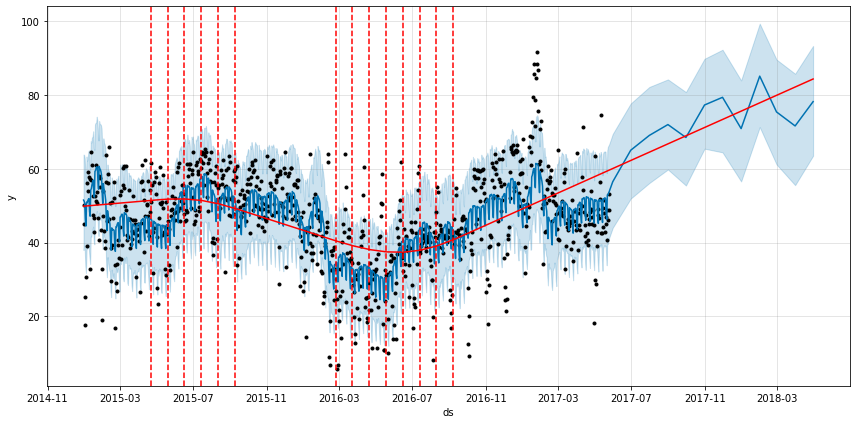

In [105]:
fig1

### Trend, yearly seasonality, and weekly seasonality of the time series

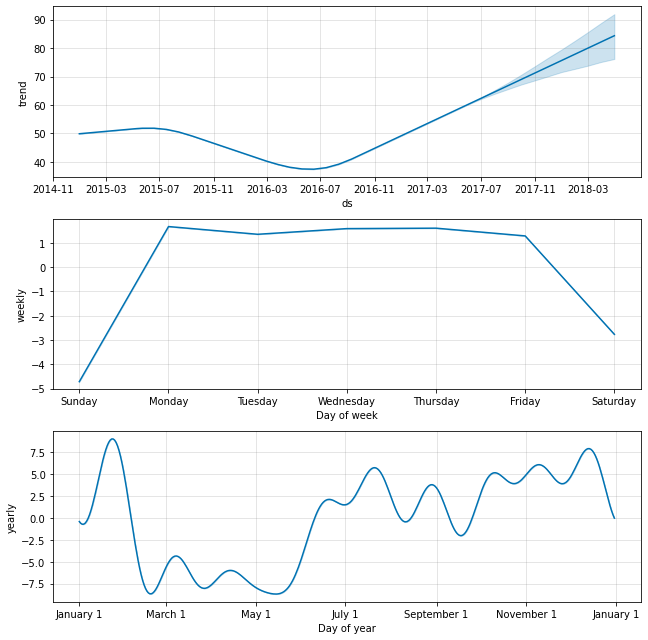

In [106]:
fig2 = prophet.plot_components(forecast)

In [ ]:
# plot_plotly(prophet, forecast)

## Reference
https://otexts.com/fpp2/stationarity.html  
https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary  
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/  